In [2]:
# Dataset - https://www.kaggle.com/datasets/salader/dogs-vs-cats

In [3]:
import zipfile
zip_ref = zipfile.ZipFile('./content/archive.zip', 'r')
zip_ref.extractall('./content')
zip_ref.close()

### Resize de imagenes
- También se eliminan los archivos corruptos
- Se cambia el formato a png 

In [4]:
import os
import cv2
IMG_SIZE = 100
scale_percent = 50

cat_path = './content/PetImages/Cat/'
catfiles = [f for f in os.listdir(cat_path) if f[-4:] == '.jpg']

for img in catfiles:
    img_path = cat_path + img
    img_arr = cv2.imread(img_path)
    if img_arr is None:
        os.remove(img_path)
        continue
    cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
    out_path = cat_path + img[:-3] + 'png'
    cv2.imwrite(out_path, img_arr)
    os.remove(img_path)

dog_path = './content/PetImages/Dog/'
catfiles = [f for f in os.listdir(dog_path) if f[-4:] == '.jpg']

for img in catfiles:
    img_path = dog_path + img
    img_arr = cv2.imread(img_path)
    if img_arr is None:
        os.remove(img_path)
        continue

    cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
    out_path = dog_path + img[:-3] + 'png'
    cv2.imwrite(out_path, img_arr)
    os.remove(img_path)


### Train - Test Split

In [5]:

import random
import shutil

# make new folders for test and train
os.mkdir('./content/train')
os.mkdir('./content/train/Cat')
os.mkdir('./content/train/Dog')
os.mkdir('./content/test')
os.mkdir('./content/test/Cat')
os.mkdir('./content/test/Dog')

# ---- Cat Files ----
# get cat image filenames
catfiles = [f for f in os.listdir('./content/PetImages/Cat/') if f[-4:] == '.png']

limit = len(catfiles)
train_indexes = []

# Get random 20%
for _ in range(int(limit * 0.2)):
    random_num = random.randint(0, limit - 1)
    while random_num in train_indexes:
        random_num = random.randint(0, limit - 1)
  
    train_indexes.append(random_num)

to_move = [catfiles[index] for index in train_indexes]

# Move test images
for img in to_move:
    shutil.move(f'./content/PetImages/Cat/{img}', f'./content/test/Cat/{img}')

# Move train images
images = [f for f in os.listdir('./content/PetImages/Cat/') if f[-4:] == '.png']
for image in images:
    new_path = './content/train/Cat/' + image
    shutil.move('./content/PetImages/Cat/' + image, new_path)

# ---- Dog Files ----
# get cat image filenames
dogfiles = [f for f in os.listdir('./content/PetImages/Dog/') if f[-4:] == '.png']

limit = len(dogfiles)
train_indexes = []

# Get random 20%
for _ in range(int(limit * 0.2)):
    random_num = random.randint(0, limit - 1)
    while random_num in train_indexes:
        random_num = random.randint(0, limit - 1)
  
    train_indexes.append(random_num)

to_move = [dogfiles[index] for index in train_indexes]

# Move test images
for img in to_move:
    shutil.move(f'./content/PetImages/Dog/{img}', f'./content/test/Dog/{img}')

# Move train images
images = [f for f in os.listdir('./content/PetImages/Dog/') if f[-4:] == '.png']

for image in images:
    new_path = './content/train/Dog/' + image
    shutil.move('./content/PetImages/Dog/' + image, new_path)


# Nueva sección

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

In [7]:
IMG_SIZE = 100

# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = './content/train',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = './content/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE)
)

Found 19957 files belonging to 2 classes.
Found 4989 files belonging to 2 classes.


In [8]:
# Normalize
def process(image,label):
    image = tf.cast(image/IMG_SIZE, tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [9]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 98, 98, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 47, 47, 64)       256       
 hNormalization)                                                 
                                                        

In [11]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
history = model.fit(train_ds,epochs=1,validation_data=validation_ds)

624/624 [==============================] - 443s 688ms/step - loss: 0.6131 - accuracy: 0.6886 - val_loss: 0.5250 - val_accuracy: 0.7380


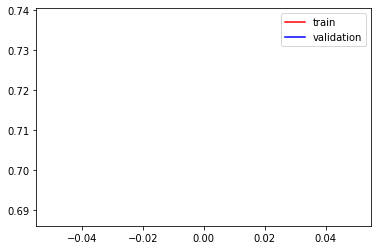

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

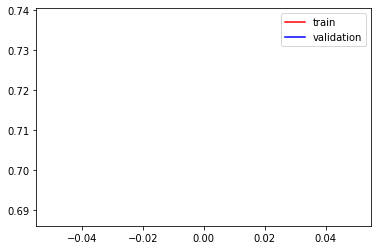

In [14]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

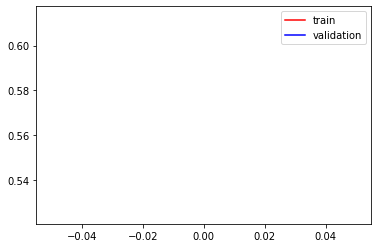

In [15]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

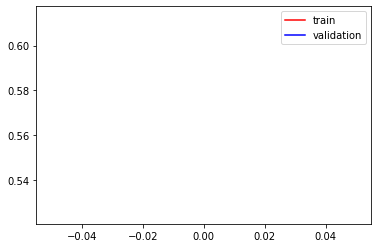

In [16]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [17]:
# ways to reduce overfitting

# Add more data
# Data Augmentation -> next video
# L1/L2 Regularizer
# Dropout
# Batch Norm
# Reduce complexity

In [18]:
import cv2

1/1 [==============================] - 0s 379ms/step


array([[1.]], dtype=float32)

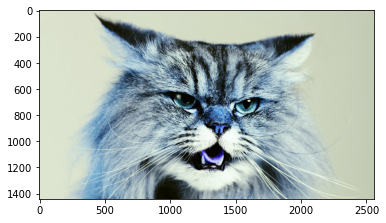

In [19]:
test_img = cv2.imread('./1521-WIRED-Cat.webp')
plt.imshow(test_img)
test_img.shape
test_img = cv2.resize(test_img,(IMG_SIZE,IMG_SIZE))
test_input = test_img.reshape((1,IMG_SIZE,IMG_SIZE,3))
model.predict(test_input)


1/1 [==============================] - 0s 21ms/step


array([[0.]], dtype=float32)

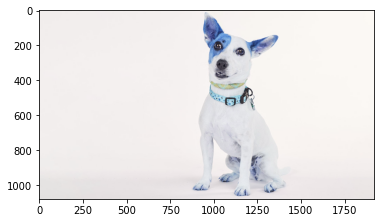

In [20]:
test_img = cv2.imread('./5061c640-5174-451b-9798-0c11f6d56b4d.jpg')
plt.imshow(test_img)
test_img.shape
test_img = cv2.resize(test_img,(IMG_SIZE,IMG_SIZE))
test_input = test_img.reshape((1,IMG_SIZE,IMG_SIZE,3))
model.predict(test_input)